In [1]:
!python -V

Python 3.12.3


In [2]:
!pwd

/home/joviedo/paraguay-public-servant-salary-calculato/data/analysis


In [3]:
!rm -rf ../raw

In [4]:
!mkdir ../raw

Descargo el dataset del sitio https://datos.sfp.gov.py/data/funcionarios/download

In [5]:
!wget -P ../raw/ https://datos.sfp.gov.py/data/funcionarios_2024_5.csv.zip

--2024-07-20 23:54:48--  https://datos.sfp.gov.py/data/funcionarios_2024_5.csv.zip
Resolving datos.sfp.gov.py (datos.sfp.gov.py)... 168.90.177.193, 200.160.0.5, 130.59.31.30, ...
Connecting to datos.sfp.gov.py (datos.sfp.gov.py)|168.90.177.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36979627 (35M) [application/zip]
Saving to: ‘../raw/funcionarios_2024_5.csv.zip’

funcionarios_2024_5 100%[===================>]  35.27M  31.4MB/s    in 1.1s    

2024-07-20 23:54:49 (31.4 MB/s) - ‘../raw/funcionarios_2024_5.csv.zip’ saved [36979627/36979627]



In [6]:
!unzip ../raw/funcionarios_2024_5.csv.zip -d ../raw/

Archive:  ../raw/funcionarios_2024_5.csv.zip
  inflating: ../raw/funcionarios_2024_5.csv  


In [7]:
!ls -l ../raw/

total 483792
-rw-r--r-- 1 joviedo joviedo 458417876 Jul 20 04:54 funcionarios_2024_5.csv
-rw-rw-r-- 1 joviedo joviedo  36979627 Jul 20 04:54 funcionarios_2024_5.csv.zip


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from category_encoders import CountEncoder, CatBoostEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import root_mean_squared_error

Cargo el dataset (archivo descargado de la pagina 

In [9]:
df_2024_05 = pd.read_csv(r'../raw/funcionarios_2024_5.csv', encoding='latin-1')

/tmp/ipykernel_34332/828777021.py:1: DtypeWarning: Columns (8,13,17,21,26,27,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2024_05 = pd.read_csv(r'../raw/funcionarios_2024_5.csv', encoding='latin-1')


Tamaño del dataset

In [10]:
df_2024_05.shape

(992223, 35)

Previsualizo el dataset

In [11]:
df_2024_05.head()

,anho,mes,nivel,descripcion_nivel,entidad,descripcion_entidad,oee,descripcion_oee,documento,nombres,...,devengado,movimiento,lugar,fecha_nacimiento,fec_ult_modif,uri,fecha_acto,correo,profesion,motivo_movimiento
0,2024,5,28,UNIVERSIDADES NACIONALES,8,UNIVERSIDAD NACIONAL DE CANINDEYU,1,UNIVERSIDAD NACIONAL DE CANINDEYU (UNCAN),VAC2210830,VACANTE,...,0,NaN,NaN,NaN,2024/06/06 14:38:04.510000000,http://datos.sfp.gov.py/id/funcionarios/0,NaN,NaN,NaN,NaN
1,2024,5,22,GOBIERNOS DEPARTAMENTALES,8,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,1,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,2895739,RICHARD ROLANDO,...,26153400,A - ALTA (INCORPORACIÓN),NaN,1984/01/14 00:00:00.000,2024/05/24 08:34:51.702000000,http://datos.sfp.gov.py/id/funcionarios/2895739,2023/08/15 00:00:00.000,rrhhgormisionespy@outlook.es,ABOGADO,"Alta, por asuncion de cargo como Gobernador"
2,2024,5,22,GOBIERNOS DEPARTAMENTALES,8,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,1,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,2895739,RICHARD ROLANDO,...,2851200,A - ALTA (INCORPORACIÓN),NaN,1984/01/14 00:00:00.000,2024/05/24 08:34:51.702000000,http://datos.sfp.gov.py/id/funcionarios/2895739,2023/08/15 00:00:00.000,rrhhgormisionespy@outlook.es,ABOGADO,"Alta, por asuncion de cargo como Gobernador"
3,2024,5,22,GOBIERNOS DEPARTAMENTALES,8,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,1,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,1749090,MARIA TOMASA,...,7425200,NaN,NaN,1977/05/19 00:00:00.000,2024/05/24 08:34:51.703000000,http://datos.sfp.gov.py/id/funcionarios/1749090,2018/08/15 00:00:00.000,rrhhgormisionespy@outlook.es,UNIVERSITARIO,NaN
4,2024,5,22,GOBIERNOS DEPARTAMENTALES,8,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,1,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,1749090,MARIA TOMASA,...,2500000,NaN,NaN,1977/05/19 00:00:00.000,2024/05/24 08:34:51.704000000,http://datos.sfp.gov.py/id/funcionarios/1749090,2018/08/15 00:00:00.000,rrhhgormisionespy@outlook.es,UNIVERSITARIO,NaN


Listo los nombres de las columnas

In [12]:
print(df_2024_05.columns)
len(df_2024_05.columns)

Index(['anho', 'mes', 'nivel', 'descripcion_nivel', 'entidad',
       'descripcion_entidad', 'oee', 'descripcion_oee', 'documento', 'nombres',
       'apellidos', 'funcion', 'estado', 'carga_horaria', 'anho_ingreso',
       'sexo', 'discapacidad', 'tipo_discapacidad', 'fuente_financiamiento',
       'objeto_gasto', 'concepto', 'linea', 'categoria', 'cargo',
       'presupuestado', 'devengado', 'movimiento', 'lugar', 'fecha_nacimiento',
       'fec_ult_modif', 'uri', 'fecha_acto', 'correo', 'profesion',
       'motivo_movimiento'],
      dtype='object')


35

In [13]:
df_2024_05.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992223 entries, 0 to 992222
Data columns (total 35 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   anho                   992223 non-null  int64 
 1   mes                    992223 non-null  int64 
 2   nivel                  992223 non-null  int64 
 3   descripcion_nivel      992223 non-null  object
 4   entidad                992223 non-null  int64 
 5   descripcion_entidad    992223 non-null  object
 6   oee                    992223 non-null  int64 
 7   descripcion_oee        992223 non-null  object
 8   documento              992223 non-null  object
 9   nombres                992223 non-null  object
 10  apellidos              992223 non-null  object
 11  funcion                883290 non-null  object
 12  estado                 992223 non-null  object
 13  carga_horaria          840852 non-null  object
 14  anho_ingreso           992223 non-null  int64 
 15  

Verifico registros duplicados

In [14]:
duplicates = df_2024_05.duplicated()
len(df_2024_05[duplicates])

1093

Elimino registros duplicados

In [15]:
df_2024_05 = df_2024_05.drop_duplicates()
df_2024_05.shape

(991130, 35)

Defino la variable objetivo

In [16]:
target = 'presupuestado'

Elimino variables sensibles (variables que pueden ser sensibles y potencialmente discriminatorias si se utilizan incorrectamente) y redundantes.

In [17]:
df_2024_05.describe().T

,count,mean,std,min,25%,50%,75%,max
anho,991130.0,2.024000e+03,0.000000e+00,2024.0,2024.0,2024.0,2024.0,2024.0
mes,991130.0,5.000000e+00,0.000000e+00,5.0,5.0,5.0,5.0,5.0
nivel,991130.0,1.653629e+01,7.139673e+00,11.0,12.0,12.0,24.0,40.0
entidad,991130.0,5.969835e+00,5.225751e+00,1.0,2.0,7.0,7.0,40.0
oee,991130.0,6.698266e+00,2.899276e+01,1.0,1.0,1.0,1.0,524.0
anho_ingreso,991130.0,1.939381e+03,3.672638e+02,0.0,2002.0,2009.0,2016.0,9999.0
fuente_financiamiento,991130.0,1.558549e+01,8.970920e+00,0.0,10.0,10.0,30.0,30.0
objeto_gasto,991130.0,1.298094e+02,3.334422e+01,0.0,111.0,131.0,136.0,874.0
presupuestado,991130.0,2.230866e+06,2.667470e+06,0.0,500000.0,1208200.0,3632977.0,220000000.0
devengado,991130.0,2.003909e+06,2.396101e+06,0.0,436000.0,1056613.0,3265920.0,149235160.0


In [18]:
df_2024_05.describe(include=[object]).T

,count,unique,top,freq
descripcion_nivel,991130,14,PODER EJECUTIVO,629897
descripcion_entidad,991130,121,MINISTERIO DE EDUCACION Y CULTURA,338253
descripcion_oee,991130,383,MINISTERIO DE EDUCACION Y CIENCIAS (MEC),338253
documento,991130,366658,656038,27
nombres,991130,85800,NOMBRES DEL FUNCIONARIO,109244
apellidos,991130,113711,APELLIDOS DEL FUNCIONARIO,109244
funcion,882312,33220,CATEDRATICO,164228
estado,991130,3,PERMANENTE,860624
carga_horaria,839879,29951,07:00 A 12:00,148619
sexo,991130,2,FEMENINO,512926


In [19]:
list_var_del = ['anho', 'mes', 'documento', 'nombres', 'apellidos', 'sexo', 'discapacidad', 'tipo_discapacidad', 'uri', 'correo', 'carga_horaria', 'fuente_financiamiento',
       'objeto_gasto', 'concepto', 'fec_ult_modif', 'fecha_acto', 'motivo_movimiento', 'devengado', 'movimiento', 'lugar', 'linea', 'fecha_nacimiento']

df_2024_05.drop(columns=list_var_del, axis=1, inplace=True)

Solo tomo registros con año de ingreso mayor a 0 y menor al año actual.
El valor de la variable objetivo debe ser mayor a 0

In [20]:
df_2024_05[(df_2024_05[target] <= 0)][target]

54        0
203       0
207       0
209       0
212       0
         ..
946260    0
946360    0
949518    0
972737    0
988983    0
Name: presupuestado, Length: 1969, dtype: int64

In [21]:
anho_actual = date.today().year
df_2024_05[(df_2024_05['anho_ingreso'] <= 0) |  (df_2024_05['anho_ingreso'] > anho_actual)]['anho_ingreso']

0         0
5         0
47        0
54        0
128       0
         ..
941613    0
941614    0
941615    0
941616    0
941617    0
Name: anho_ingreso, Length: 34277, dtype: int64

In [22]:
df_2024_05 = df_2024_05[(df_2024_05[target] > 0) & (df_2024_05['anho_ingreso'] > 0) & (df_2024_05['anho_ingreso'] <= anho_actual)]
df_2024_05.shape

(955218, 13)

Calculo la antiguedad laboral y elimino el año de ingreso

In [23]:
df_2024_05['antiguedad_laboral'] = anho_actual - df_2024_05['anho_ingreso']
df_2024_05.drop(columns=['anho_ingreso'], index=1, inplace=True)
df_2024_05 = df_2024_05[df_2024_05.antiguedad_laboral <= 50]
df_2024_05.shape

(954980, 13)

In [24]:
df_2024_05.head()

,nivel,descripcion_nivel,entidad,descripcion_entidad,oee,descripcion_oee,funcion,estado,categoria,cargo,presupuestado,profesion,antiguedad_laboral
2,22,GOBIERNOS DEPARTAMENTALES,8,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,1,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,GOBERNADOR,PERMANENTE,A46,GOBERNADOR,2851200,ABOGADO,1
3,22,GOBIERNOS DEPARTAMENTALES,8,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,1,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,SECRETARIA DE LA MUJER,PERMANENTE,C90,SECRETARIO DEPARTAMENTAL,7425200,UNIVERSITARIO,6
4,22,GOBIERNOS DEPARTAMENTALES,8,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,1,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,SECRETARIA DE LA MUJER,PERMANENTE,C90,SECRETARIO DEPARTAMENTAL,2500000,UNIVERSITARIO,6
6,22,GOBIERNOS DEPARTAMENTALES,8,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,1,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,SECRETARIO DE AGRICULTURA,PERMANENTE,C90,SECRETARIO DEPARTAMENTAL,7425200,INGENIERO,6
7,22,GOBIERNOS DEPARTAMENTALES,8,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,1,VIII DEPARTAMENTO: GOBERNACION DE MISIONES,SECRETARIO DE AGRICULTURA,PERMANENTE,C90,SECRETARIO DEPARTAMENTAL,2500000,INGENIERO,6


In [25]:
df_2024_05.dtypes

nivel                   int64
descripcion_nivel      object
entidad                 int64
descripcion_entidad    object
oee                     int64
descripcion_oee        object
funcion                object
estado                 object
categoria              object
cargo                  object
presupuestado           int64
profesion              object
antiguedad_laboral      int64
dtype: object

In [26]:
list_var_categoricas = ['descripcion_nivel', 'descripcion_entidad', 'descripcion_oee', 'cargo', 'funcion', 'estado', 'categoria', 'profesion', 'nivel', 'entidad', 'oee']

df_2024_05[list_var_categoricas] = df_2024_05[list_var_categoricas].astype(str)

In [27]:
df_2024_05_copy = df_2024_05.copy()

countencoder = CountEncoder(cols=list_var_categoricas, handle_missing='n/a')

df_countencoder_var_no_numericas = countencoder.fit_transform(df_2024_05[list_var_categoricas])
df_2024_05_copy[list_var_categoricas] = df_countencoder_var_no_numericas
df_2024_05_copy[list_var_categoricas].head()

,descripcion_nivel,descripcion_entidad,descripcion_oee,cargo,funcion,estado,categoria,profesion,nivel,entidad,oee
2,4094,185,185,35,34,833761,257,28094,4094,124165,769148
3,4094,185,185,253,21,833761,276,12746,4094,124165,769148
4,4094,185,185,253,21,833761,276,12746,4094,124165,769148
6,4094,185,185,253,18,833761,276,3761,4094,124165,769148
7,4094,185,185,253,18,833761,276,3761,4094,124165,769148


Elimino variables que tengan entre si una correlacion absoluta mayor a 0.80

<Axes: >

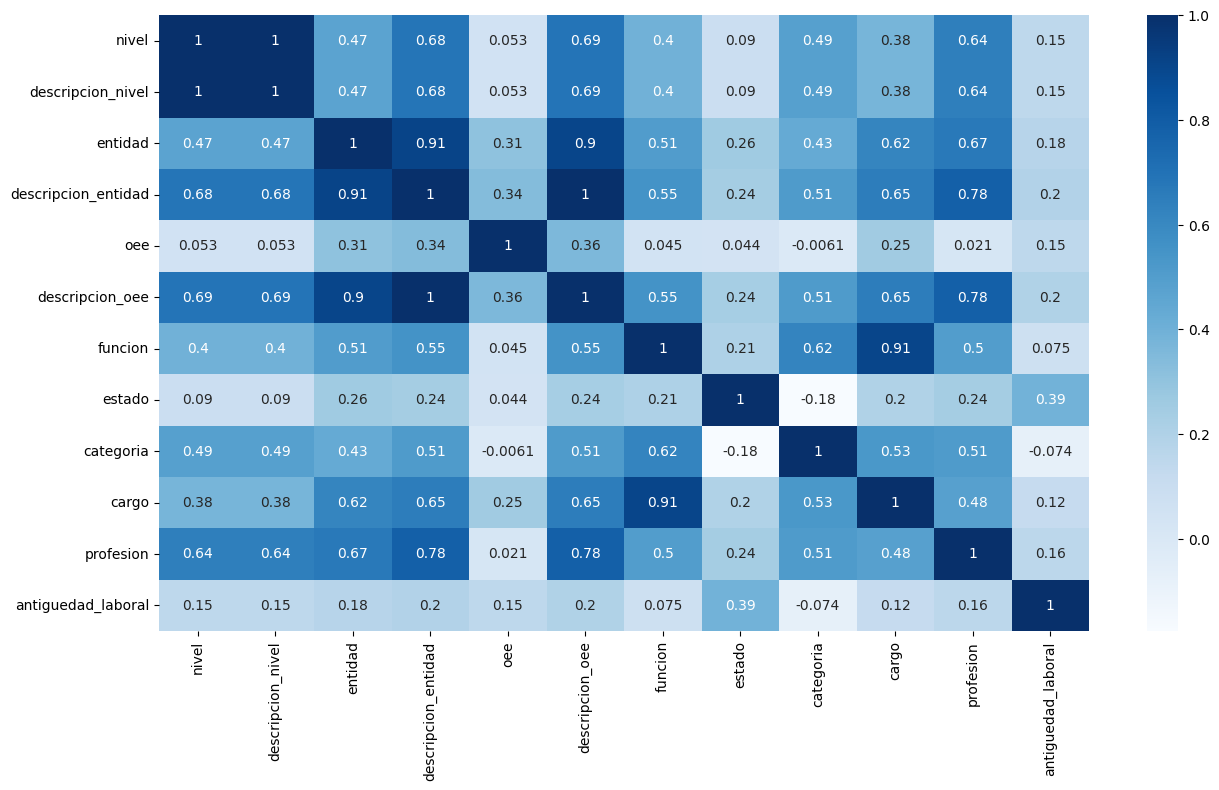

In [28]:
df_not_target = df_2024_05_copy.drop(target, axis=1)
df_corr = df_not_target.corr()
plt.figure(figsize=(15,8))
sns.heatmap(df_corr, annot=True, cmap='Blues')

In [29]:
df_corr.nivel[df_corr.nivel > 0.80]

nivel                1.0
descripcion_nivel    1.0
Name: nivel, dtype: float64

In [30]:
df_corr.descripcion_nivel[df_corr.descripcion_nivel > 0.80]

nivel                1.0
descripcion_nivel    1.0
Name: descripcion_nivel, dtype: float64

In [31]:
df_corr.entidad[df_corr.entidad > 0.80]

entidad                1.000000
descripcion_entidad    0.910213
descripcion_oee        0.904871
Name: entidad, dtype: float64

In [32]:
df_corr.descripcion_entidad[df_corr.descripcion_entidad > 0.80]

entidad                0.910213
descripcion_entidad    1.000000
descripcion_oee        0.999136
Name: descripcion_entidad, dtype: float64

In [33]:
df_corr.descripcion_oee[df_corr.descripcion_oee > 0.80]

entidad                0.904871
descripcion_entidad    0.999136
descripcion_oee        1.000000
Name: descripcion_oee, dtype: float64

In [34]:
df_corr.cargo[df_corr.cargo > 0.80]

funcion    0.906608
cargo      1.000000
Name: cargo, dtype: float64

In [35]:
df_corr.funcion[df_corr.funcion > 0.80]

funcion    1.000000
cargo      0.906608
Name: funcion, dtype: float64

In [36]:
df_corr.categoria[df_corr.categoria > 0.80]

categoria    1.0
Name: categoria, dtype: float64

In [37]:
df_corr.profesion[df_corr.profesion > 0.80]

profesion    1.0
Name: profesion, dtype: float64

In [38]:
df_corr.antiguedad_laboral[df_corr.antiguedad_laboral > 0.80]

antiguedad_laboral    1.0
Name: antiguedad_laboral, dtype: float64

In [39]:
df_corr.oee[df_corr.oee > 0.80]

oee    1.0
Name: oee, dtype: float64

Respecto a la oee:  en este nivel la Secretaría de la Función Pública asocia a las Municipalidades y Universidades una codificación distinta al Presupuesto General de la Nación. Las municipalidades en este nivel tienen asignados el número dentro de su departamento correspondiente. La Universidad Nacional en este nivel se desglosa en las diferentes facultades y/o instituciones dependientes de ella. 

Por tanto la oee tiene la misma información que la descripción oee (esta ultima es redundante al comparar con la descripcion de la entidad).

In [40]:
df_2024_05["oee"].value_counts()

oee
1      769148
2      109666
8       15789
4        3582
12       3442
        ...  
49         28
524        26
38         25
263        23
259         1
Name: count, Length: 239, dtype: int64

In [41]:
df_2024_05["descripcion_oee"].value_counts()

descripcion_oee
MINISTERIO DE EDUCACION Y CIENCIAS (MEC)                        338183
MINISTERIO DE SALUD PUBLICA Y BIENESTAR SOCIAL (MSPBS)          122633
POLICIA NACIONAL (PN)                                           104028
INSTITUTO DE PREVISION SOCIAL (IPS)                              76715
ADMINISTRACION NACIONAL DE ELECTRICIDAD (ANDE)                   50505
                                                                 ...  
MUNICIPALIDAD DE ITACUA                                             23
INSTITUTO NACIONAL DEL AUDIOVISUAL PARAGUAYO                        19
CAJA DE SEGURIDAD SOCIAL DE EMPLEADOS Y OBREROS FERROVIARIOS        18
CAJA DE PRESTAMOS DEL MINISTERIO DE DEFENSA NACIONAL (CPMDN)        11
MUNICIPALIDAD DE CERRO CORÁ                                          1
Name: count, Length: 382, dtype: int64

In [42]:
df_2024_05["descripcion_entidad"].value_counts()

descripcion_entidad
MINISTERIO DE EDUCACION Y CULTURA                               338183
MINISTERIO DE SALUD PUBLICA Y BIENESTAR SOCIAL                  122633
MINISTERIO DEL INTERIOR                                         104533
INSTITUTO DE PREVISION SOCIAL                                    76715
ADMINISTRACION NACIONAL DE ELECTRICIDAD                          50505
                                                                 ...  
MECANISMO NACIONAL DE PREVENSIÓN CONTRA LA TORTURA                  51
DIRECCIÓN NACIONAL DE DEFENSA, SALUD Y BIENESTAR ANIMAL             37
INSTITUTO NACIONAL DEL AUDIOVISUAL  PARAGUAYO                       19
CAJA DE SEGURIDAD SOCIAL DE EMPLEADOS Y OBREROS FERROVIARIOS        18
CAJA DE PRESTAMOS DEL MINISTERIO DE DEFENSA NACIONAL                11
Name: count, Length: 121, dtype: int64

Las caracteristicas a utilizar son:

In [43]:
features = ['nivel', 'entidad', 'cargo', 'estado', 'categoria', 'profesion', 'antiguedad_laboral']
df_2024_05 = df_2024_05[features + [target]]
df_2024_05

,nivel,entidad,cargo,estado,categoria,profesion,antiguedad_laboral,presupuestado
2,22,8,GOBERNADOR,PERMANENTE,A46,ABOGADO,1,2851200
3,22,8,SECRETARIO DEPARTAMENTAL,PERMANENTE,C90,UNIVERSITARIO,6,7425200
4,22,8,SECRETARIO DEPARTAMENTAL,PERMANENTE,C90,UNIVERSITARIO,6,2500000
6,22,8,SECRETARIO DEPARTAMENTAL,PERMANENTE,C90,INGENIERO,6,7425200
7,22,8,SECRETARIO DEPARTAMENTAL,PERMANENTE,C90,INGENIERO,6,2500000
...,...,...,...,...,...,...,...,...
992218,25,2,ASISTENTE ADMINISTRATIVO IV C,PERMANENTE,A12,BACHILLERATO,12,137350
992219,25,2,ASISTENTE ADMINISTRATIVO IV C,PERMANENTE,A12,BACHILLERATO,12,3645810
992220,25,2,ASISTENTE ADMINISTRATIVO IV C,PERMANENTE,A12,BACHILLERATO,12,245198
992221,25,2,ASISTENTE ADMINISTRATIVO IV C,PERMANENTE,A12,BACHILLERATO,12,270060


In [44]:
!rm -rf ../processed
!mkdir ../processed
df_2024_05.to_csv('../processed/funcionarios_2024_5_clean.csv')

Cardinalidad de las caracteristicas

In [45]:
df_2024_05.nunique()

nivel                    14
entidad                  39
cargo                 16683
estado                    3
categoria              2699
profesion              6321
antiguedad_laboral       51
presupuestado         63087
dtype: int64

In [46]:
df_2024_05.describe().T

,count,mean,std,min,25%,50%,75%,max
antiguedad_laboral,954980.0,1.515385e+01,9.117116e+00,0.0,8.0,15.0,21.0,50.0
presupuestado,954980.0,2.196038e+06,2.615208e+06,335.0,500000.0,1191515.5,3632977.0,220000000.0


In [47]:
df_2024_05.describe(include=[object]).T

,count,unique,top,freq
nivel,954980,14,12,612742
entidad,954980,39,7,346879
cargo,954980,16683,CATEDRATICO,164694
estado,954980,3,PERMANENTE,833761
categoria,954980,2699,SIN CATEGORÍA,152382
profesion,954980,6321,PROFESOR,215704


In [48]:
df_2024_05.info()

<class 'pandas.core.frame.DataFrame'>
Index: 954980 entries, 2 to 992222
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   nivel               954980 non-null  object
 1   entidad             954980 non-null  object
 2   cargo               954980 non-null  object
 3   estado              954980 non-null  object
 4   categoria           954980 non-null  object
 5   profesion           954980 non-null  object
 6   antiguedad_laboral  954980 non-null  int64 
 7   presupuestado       954980 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 65.6+ MB


In [49]:
features_categorica = ['nivel', 'entidad', 'cargo', 'estado', 'categoria', 'profesion'] 
features_numeric = ['antiguedad_laboral']

In [50]:
cat_boost_encoder = CatBoostEncoder(cols=features_categorica)

df_2024_05_transformed = cat_boost_encoder.fit_transform(df_2024_05[features], df_2024_05[target])
df_2024_05_transformed

,nivel,entidad,cargo,estado,categoria,profesion,antiguedad_laboral
2,2.196038e+06,2.196038e+06,2.196038e+06,2.196038e+06,2.196038e+06,2.196038e+06,1
3,2.523619e+06,2.523619e+06,2.196038e+06,2.523619e+06,2.196038e+06,2.196038e+06,6
4,4.157479e+06,4.157479e+06,4.810619e+06,4.157479e+06,4.810619e+06,4.810619e+06,6
6,3.743110e+06,3.743110e+06,4.040413e+06,3.743110e+06,4.040413e+06,2.196038e+06,6
7,4.479528e+06,4.479528e+06,4.886610e+06,4.479528e+06,4.886610e+06,4.810619e+06,6
...,...,...,...,...,...,...,...
992218,1.601697e+06,1.559678e+06,8.957841e+05,2.122819e+06,9.128731e+05,1.384006e+06,12
992219,1.601675e+06,1.559658e+06,8.943085e+05,2.122817e+06,9.113760e+05,1.383981e+06,12
992220,1.601706e+06,1.559687e+06,8.996512e+05,2.122819e+06,9.166447e+05,1.384026e+06,12
992221,1.601685e+06,1.559669e+06,8.983829e+05,2.122817e+06,9.153534e+05,1.384004e+06,12


In [51]:
df_2024_05_transformed[target] = df_2024_05[target]
df_2024_05_transformed

,nivel,entidad,cargo,estado,categoria,profesion,antiguedad_laboral,presupuestado
2,2.196038e+06,2.196038e+06,2.196038e+06,2.196038e+06,2.196038e+06,2.196038e+06,1,2851200
3,2.523619e+06,2.523619e+06,2.196038e+06,2.523619e+06,2.196038e+06,2.196038e+06,6,7425200
4,4.157479e+06,4.157479e+06,4.810619e+06,4.157479e+06,4.810619e+06,4.810619e+06,6,2500000
6,3.743110e+06,3.743110e+06,4.040413e+06,3.743110e+06,4.040413e+06,2.196038e+06,6,7425200
7,4.479528e+06,4.479528e+06,4.886610e+06,4.479528e+06,4.886610e+06,4.810619e+06,6,2500000
...,...,...,...,...,...,...,...,...
992218,1.601697e+06,1.559678e+06,8.957841e+05,2.122819e+06,9.128731e+05,1.384006e+06,12,137350
992219,1.601675e+06,1.559658e+06,8.943085e+05,2.122817e+06,9.113760e+05,1.383981e+06,12,3645810
992220,1.601706e+06,1.559687e+06,8.996512e+05,2.122819e+06,9.166447e+05,1.384026e+06,12,245198
992221,1.601685e+06,1.559669e+06,8.983829e+05,2.122817e+06,9.153534e+05,1.384004e+06,12,270060


In [52]:
df_2024_05_transformed.to_csv('../processed/funcionarios_2024_5_transformed.csv')

In [53]:
X_train, y_train = df_2024_05_transformed[features], df_2024_05_transformed[target]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

Model RandomForestRegressor

In [55]:
random_forest_regressor_model = RandomForestRegressor(n_estimators=10, random_state=42)
random_forest_regressor_model.fit(X_train, y_train)

y_pred = random_forest_regressor_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"rmse {rmse}")

rmse 1765321.9160948796


Model XGBoost

In [70]:
xgb_regressor_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=1000, learning_rate=0.1, random_state=42)
xgb_regressor_model.fit(X_train, y_train)

y_pred = xgb_regressor_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"rmse {rmse}")

rmse 1686904.6082094938


Model LightGBM

In [72]:
lgbm_regressor_model = lgb.LGBMRegressor(objective='regression', n_estimators=1000, learning_rate=0.1, random_state=42)
lgbm_regressor_model.fit(X_train, y_train)

y_pred = lgbm_regressor_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"rmse {rmse}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1581
[LightGBM] [Info] Number of data points in the train set: 716235, number of used features: 7
[LightGBM] [Info] Start training from score 2197529.629823
rmse 1666357.7253863777


In [ ]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()